In [1]:
import tensorflow as tf

from keras import layers
from keras.datasets import mnist
from keras.models import Sequential

import matplotlib.pyplot as plt
from keras.layers import Dense, Conv2D
import tensorflow.keras.backend as K
from keras.utils import to_categorical

import os
import keras
from keras.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np
from scikitplot.metrics import plot_confusion_matrix, plot_roc

Using TensorFlow backend.


8
Epoch 1/5
60000/60000 [==============================] - 20s 334us/step - loss: 0.2012 - accuracy: 0.9400

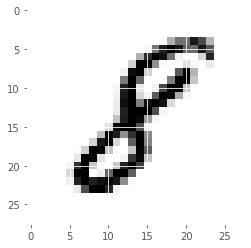

In [33]:
(trainingSet, trainingLabel), (testSet, testLabel) = mnist.load_data()


image_index = 7777
print(trainingLabel[image_index])  # The label is 8
plt.imshow(trainingSet[image_index], cmap='Greys')

plt.show()


model = Sequential()
model.add(layers.Dense(784, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dense(784, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


trainingSet = trainingSet.reshape((60000, 28 * 28))
trainingSet = trainingSet.astype('float32') / 255
testSet = testSet.reshape((10000, 28 * 28))
testSet = testSet.astype('float32') / 255

trainingLabel = to_categorical(trainingLabel)
testLabel = to_categorical(testLabel)

model.fit(trainingSet, trainingLabel, epochs=5, batch_size=128)

test_loss, test_acc = model.evaluate(testSet, testLabel)
print('test_acc:', test_acc, 'test_loss', test_loss)

# LeNet 5 Architecture

In [20]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
 
rows, cols = 28, 28
 
x_train = x_train.reshape(x_train.shape[0], rows, cols, 1)
x_test = x_test.reshape(x_test.shape[0], rows, cols, 1)
 
input_shape = (rows, cols, 1)
 
# convert to float and normalize
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0
 
# one-hot encode the labels
#y_train = tf.keras.utils.to_categorical(y_train, 10)
#y_test = tf.keras.utils.to_categorical(y_test, 10)


y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

validation_data = x_test, y_test 

## Constructing the model with LeNet params

In [64]:

# sequentail API
model = tf.keras.Sequential()
# convolutional layer 1
model.add(tf.keras.layers.Conv2D(filters=6, 
                               kernel_size=(5, 5), 
                               strides=(1, 1),
                               activation='sigmoid', 
                               input_shape=input_shape))
# average pooling layer 1
model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2), 
                                         strides=(2, 2)))
# convolutional layer 2
model.add(tf.keras.layers.Conv2D(filters=16, 
                               kernel_size=(5, 5), 
                               strides=(1, 1), 
                               activation='sigmoid'))
# average pooling layer 2 
model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2), 
                                         strides=(2, 2)))
model.add(tf.keras.layers.Flatten())
# fully connected
model.add(tf.keras.layers.Dense(units=120, 
                               activation='tanh'))
model.add(tf.keras.layers.Flatten())
# fully connected
model.add(tf.keras.layers.Dense(units=84, activation='tanh'))
# output layer
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))
  
  
  
  
 

## Creating custom metrics class and callback for ROC and confusion matrix

In [65]:


def recall_score(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision_score(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [66]:
class MulticlassTruePositives(tf.keras.metrics.Metric):
    def __init__(self, name='multiclass_true_positives', **kwargs):
        super(MulticlassTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, 'int32') == tf.cast(y_pred, 'int32')
        values = tf.cast(values, 'float32')
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, 'float32')
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.)

In [67]:
learningRate = 0.001
batchSize = 32

model.compile(tf.keras.optimizers.Adam(lr=learningRate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy',
                       keras.metrics.categorical_accuracy,
                       f1_score, 
                       recall_score, 
                       precision_score,
                       tf.keras.metrics.TopKCategoricalAccuracy(k=5),
                       MulticlassTruePositives()])

In [68]:
class PerformanceVisualizationCallback(Callback):
    def __init__(self, model, testing_data, image_dir):
        super().__init__()
        self.model = model
        self.testing_data = testing_data
        
        os.makedirs(image_dir, exist_ok=True)
        self.image_dir = image_dir

    def on_epoch_end(self, epoch, logs={}):
        y_pred = np.asarray(self.model.predict(self.testing_data[0]))
        y_true = self.testing_data[1]             
        y_pred_class = np.argmax(y_pred, axis=1)

        # plot and save confusion matrix
        fig, ax = plt.subplots(figsize=(16,12))
        plot_confusion_matrix(y_true, y_pred_class, ax=ax)
        fig.savefig(os.path.join(self.image_dir, f'confusion_matrix_epoch_{epoch}'))

       # plot and save roc curve
        fig, ax = plt.subplots(figsize=(16,12))
        plot_roc(y_true, y_pred, ax=ax)
        fig.savefig(os.path.join(self.image_dir, f'roc_curve_epoch_{epoch}'))
        
        # Plot precision-recall curve
        

performance_viz_cbk = PerformanceVisualizationCallback(
                                       model=model,
                                       testing_data=(x_test, y_test),
                                       image_dir='performance_charts')

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 20s 376us/sample - loss: 0.5857 - accuracy: 0.8059 - categorical_accuracy: 0.1055 - f1_score: 0.8520 - recall_score: 0.8219 - precision_score: 0.8975 - top_k_categorical_accuracy: 0.3688 - multiclass_true_positives: 43517.0000 - val_loss: 0.1767 - val_accuracy: 0.9467 - val_categorical_accuracy: 0.0980 - val_f1_score: 0.9880 - val_recall_score: 0.9767 - val_precision_score: 1.0000 - val_top_k_categorical_accuracy: 0.3755 - val_multiclass_true_positives: 5680.0000

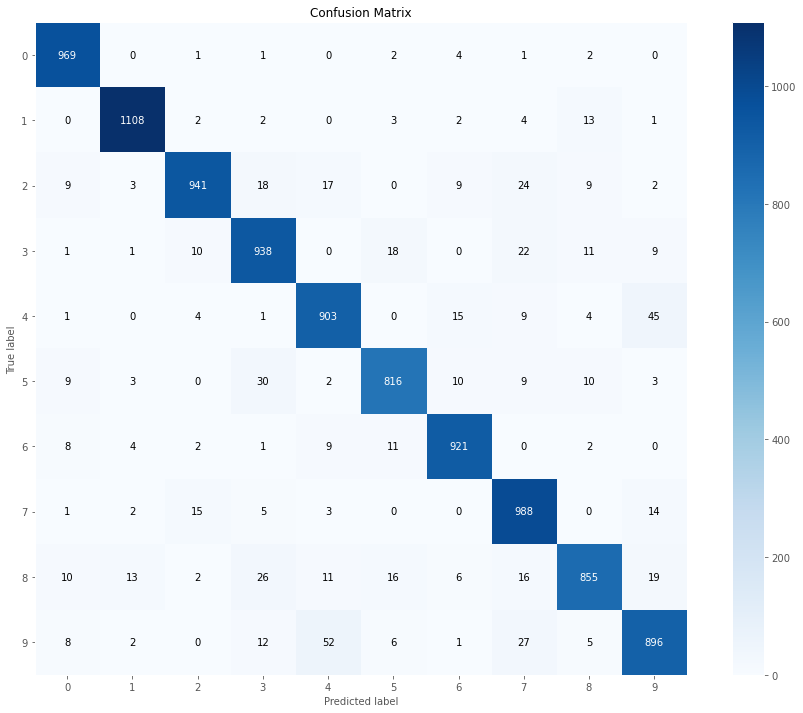

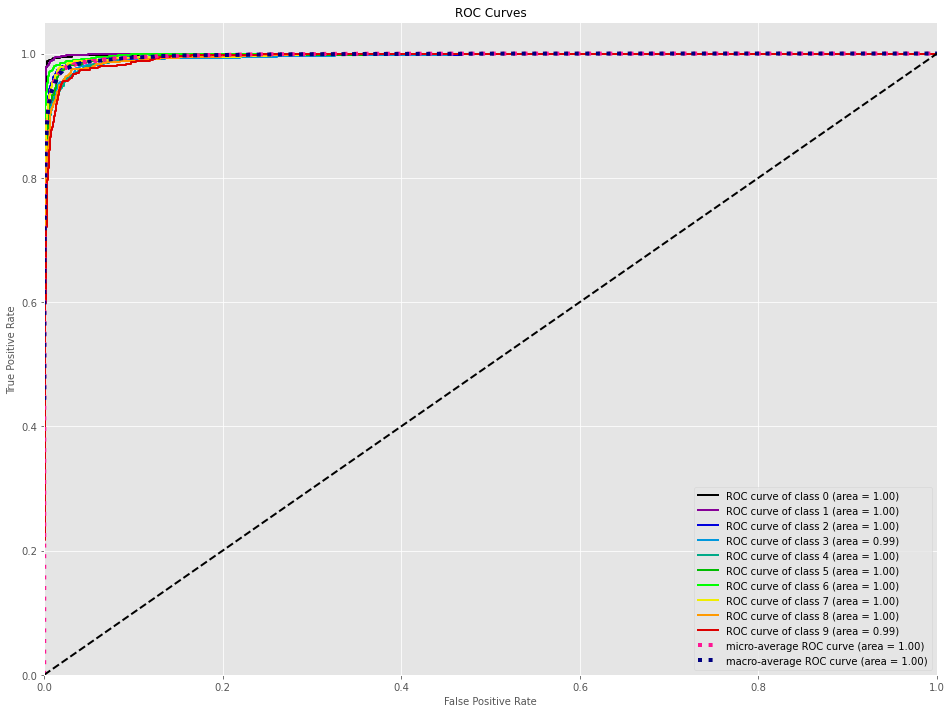

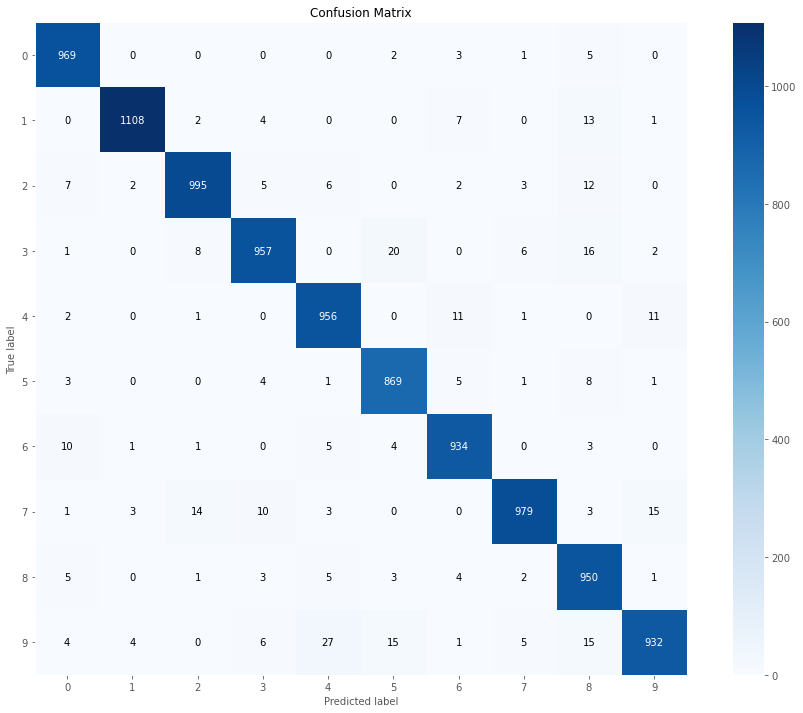

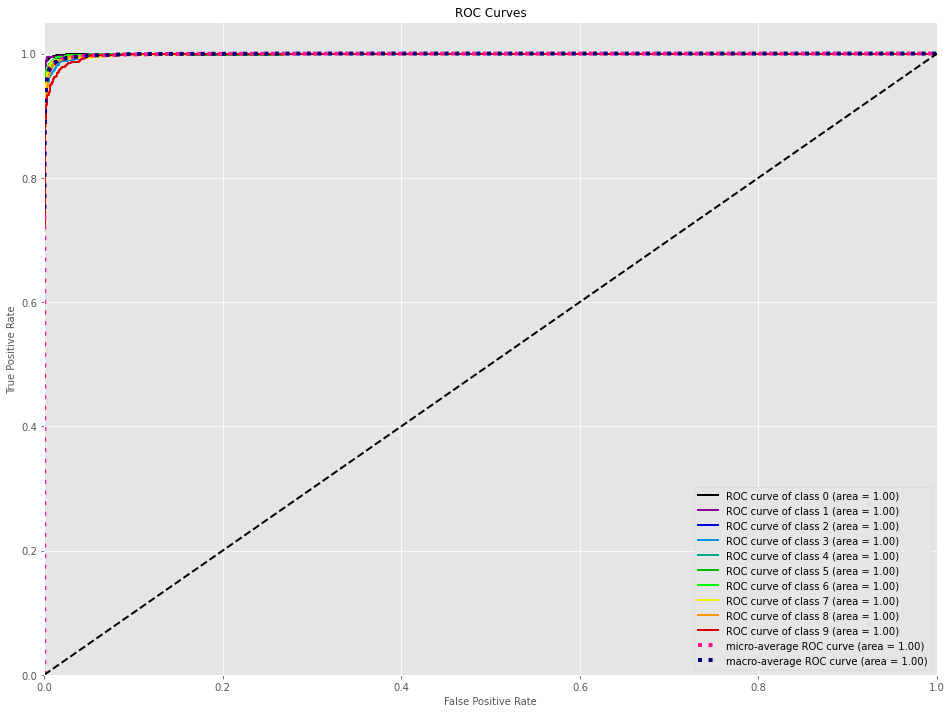

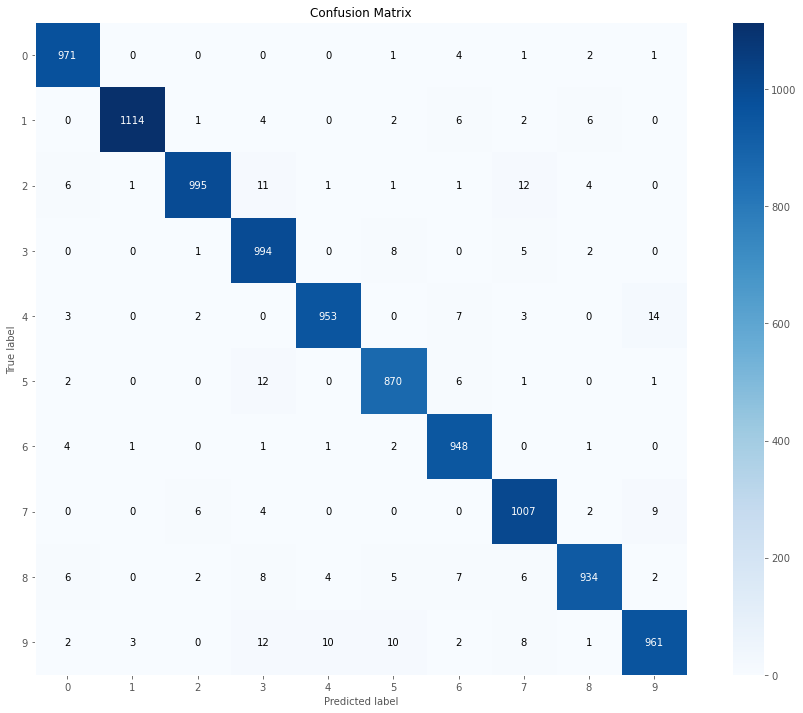

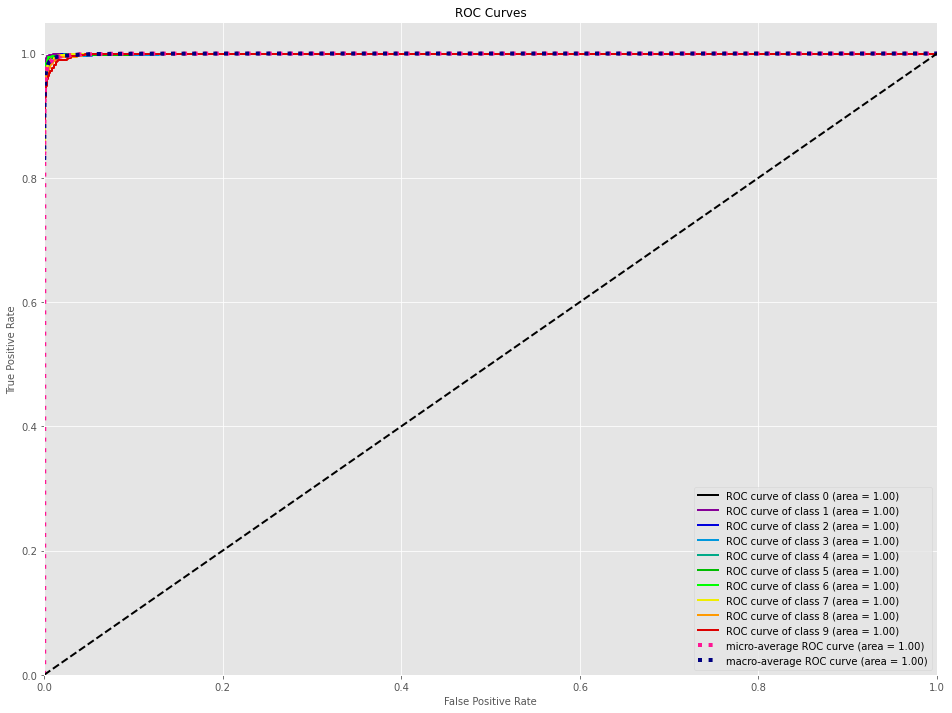

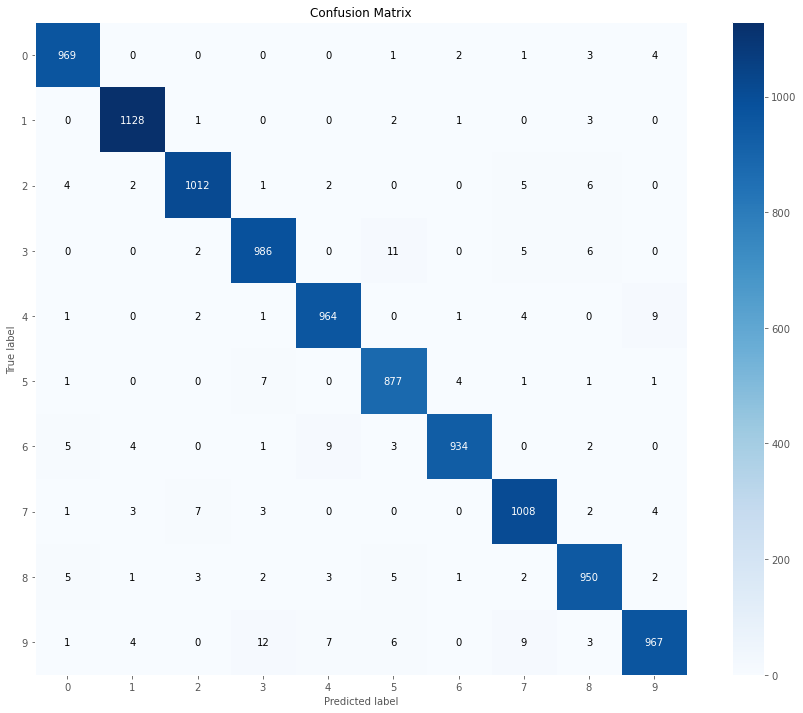

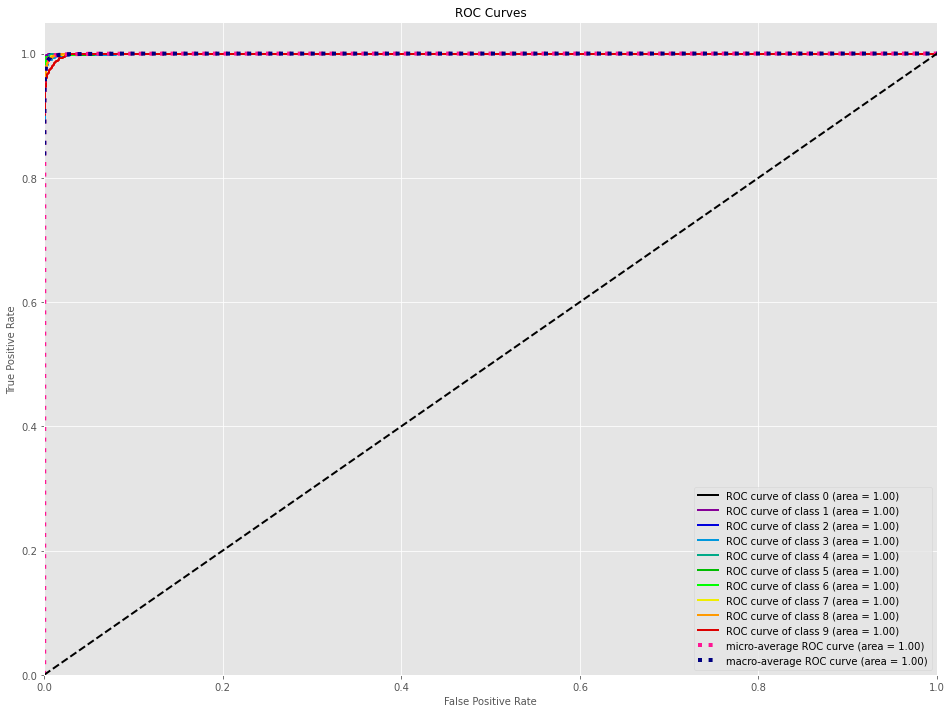

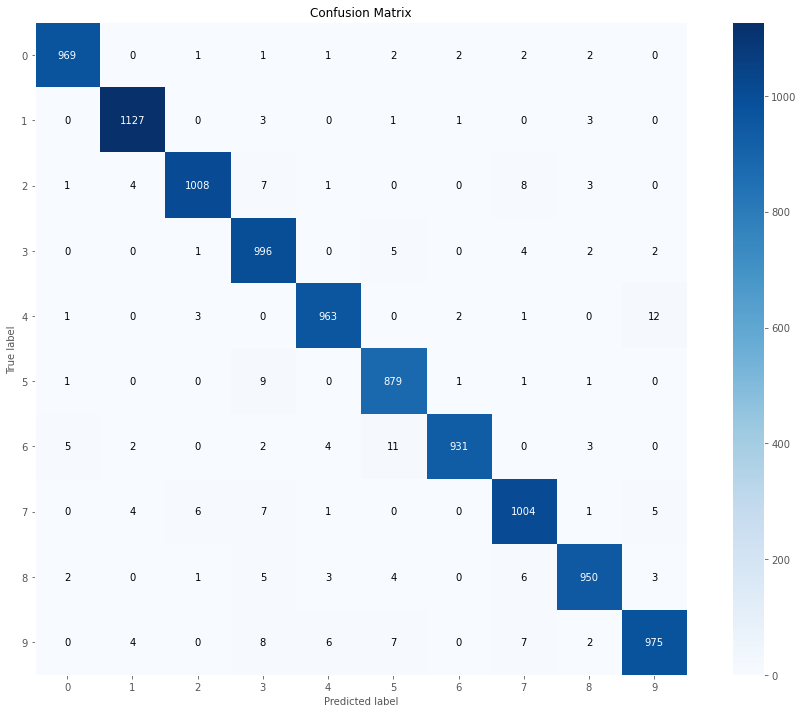

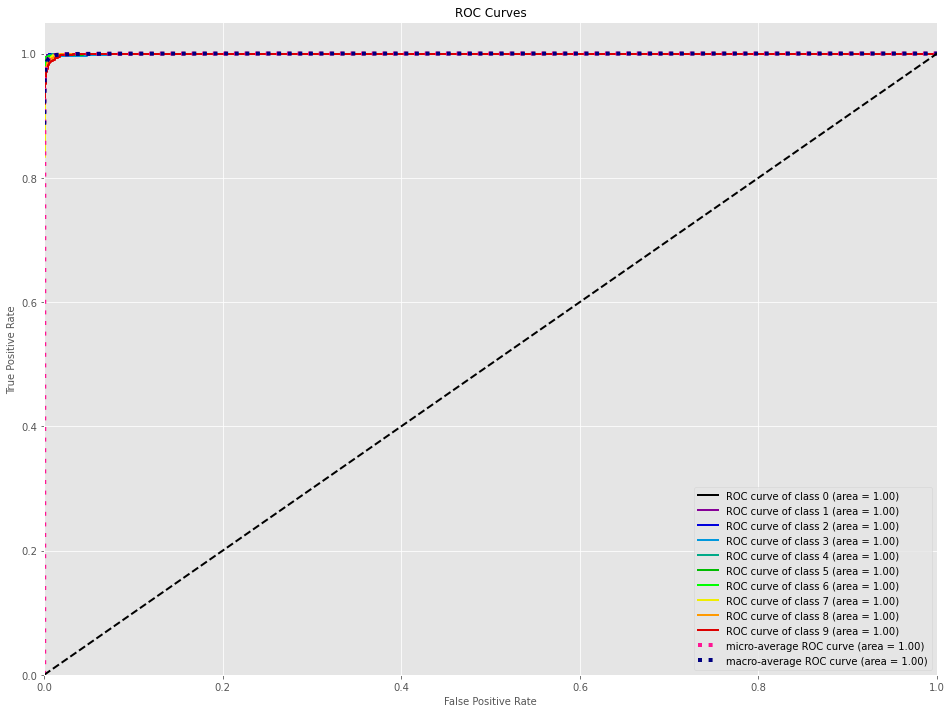

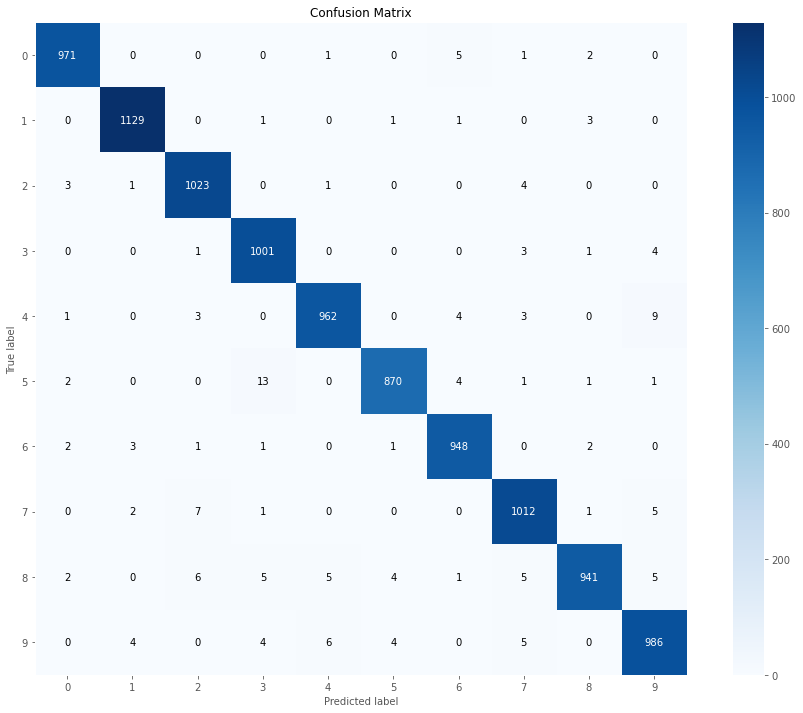

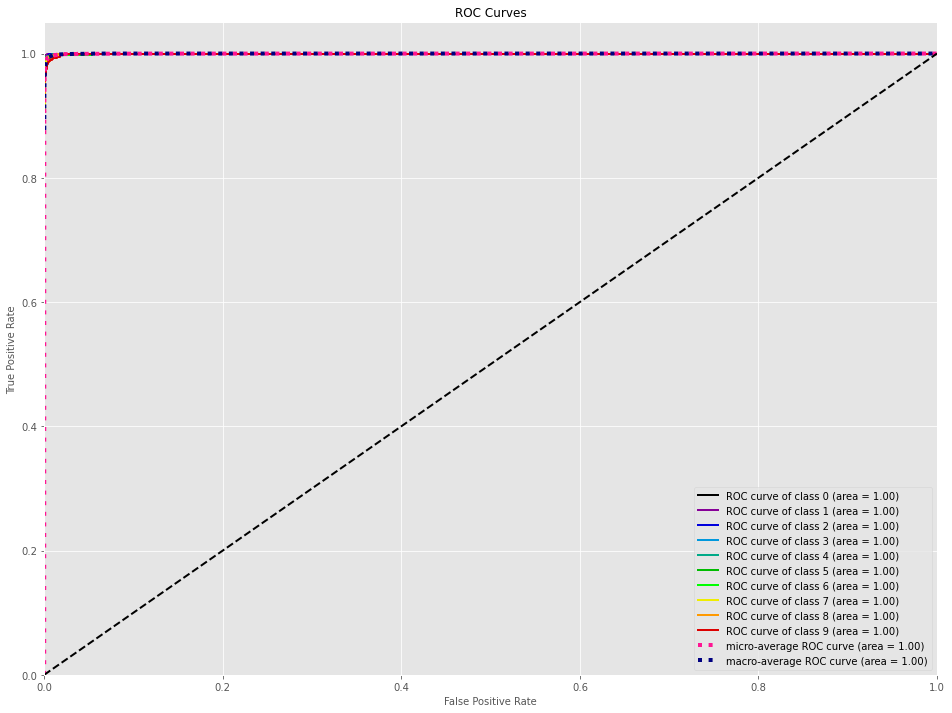

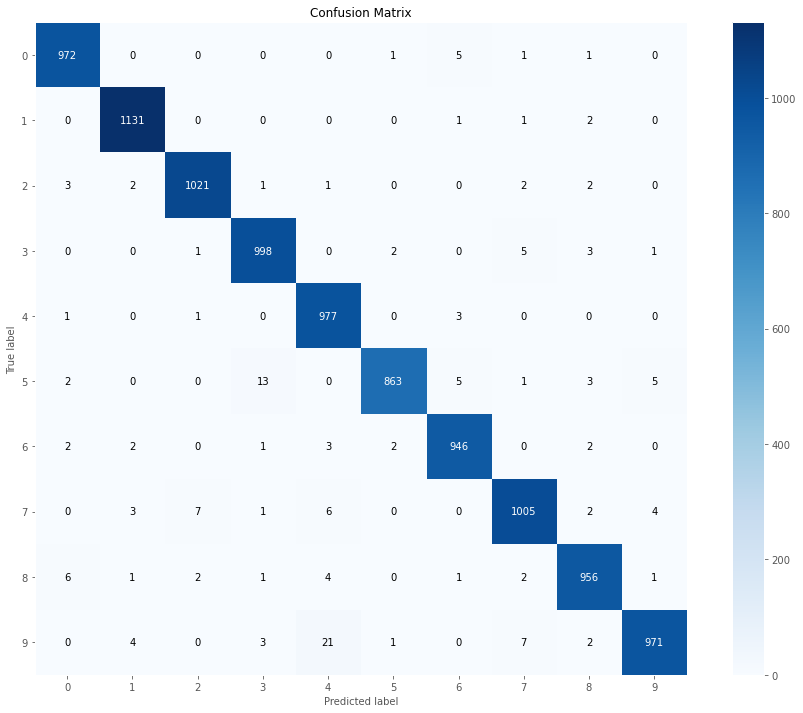

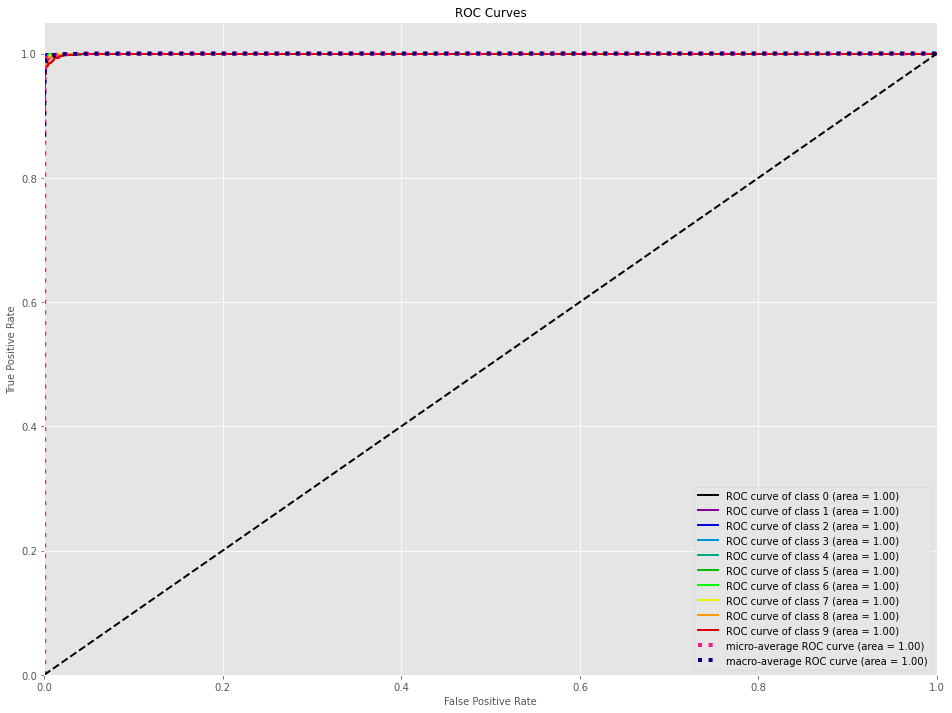

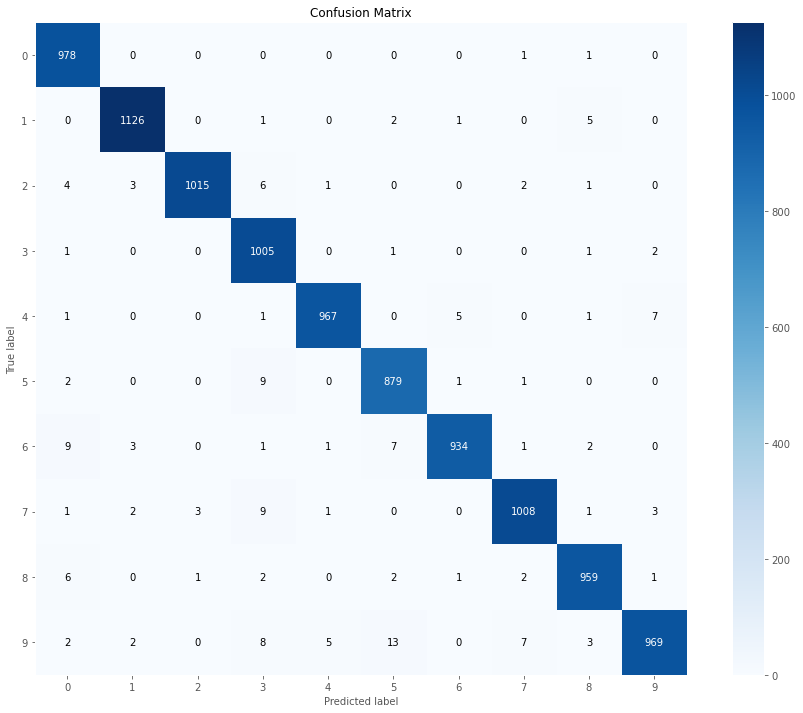

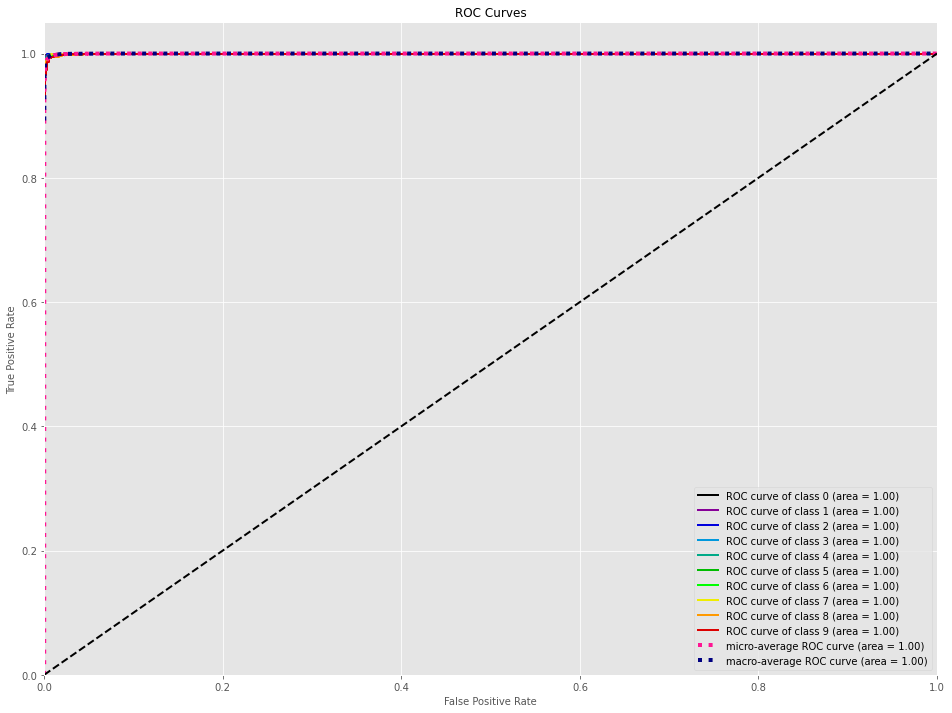

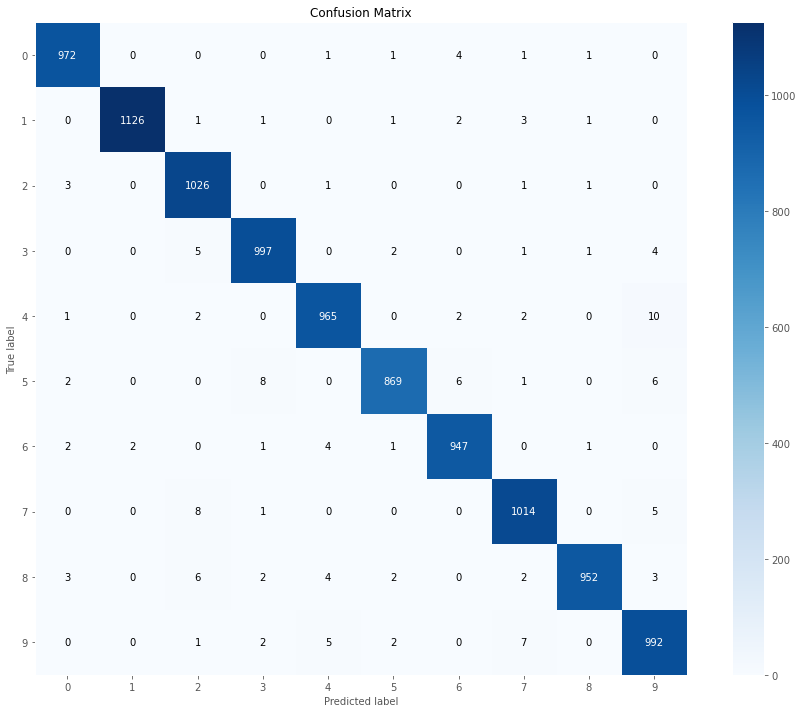

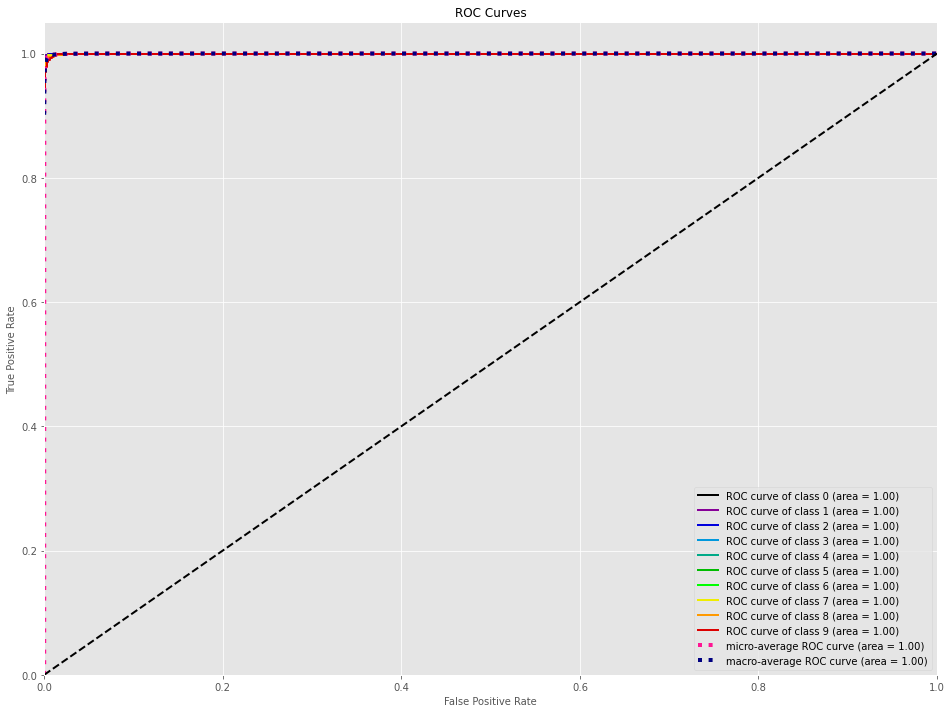

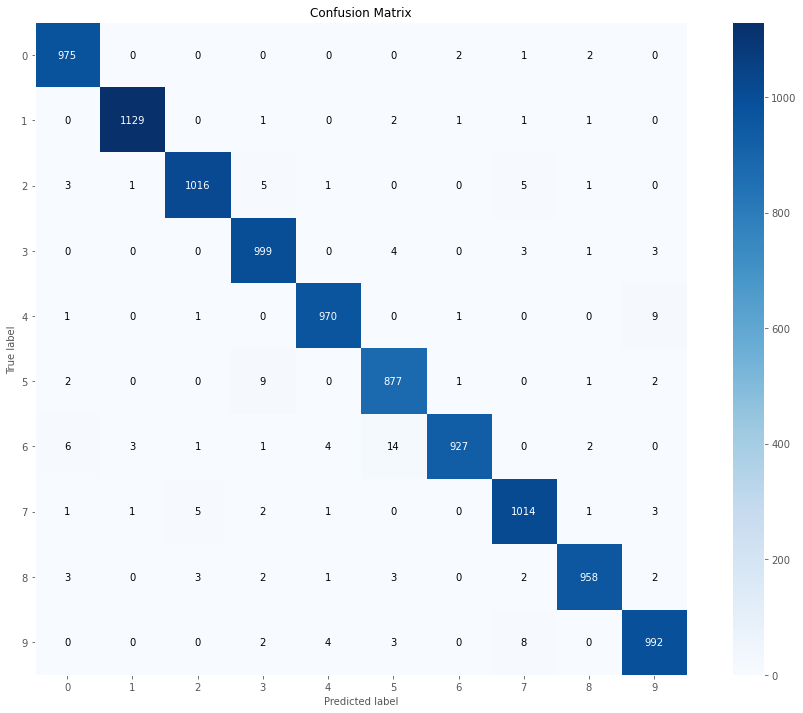

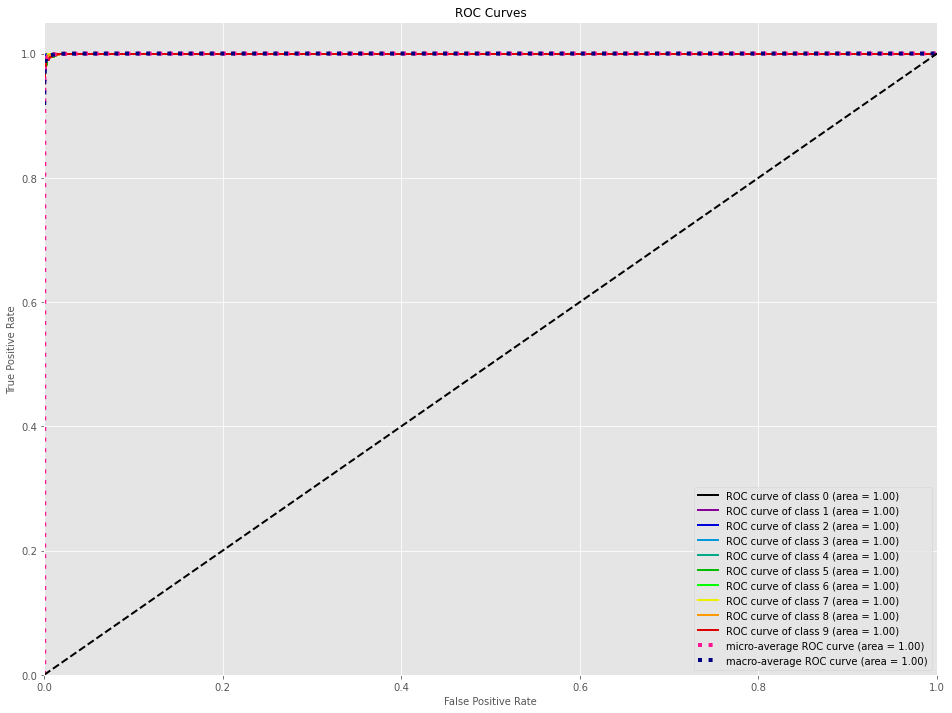

In [69]:
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=10, batch_size = batchSize,
                    validation_split = 0.1,
                    callbacks=[performance_viz_cbk])
                                                                                           



model.summary()

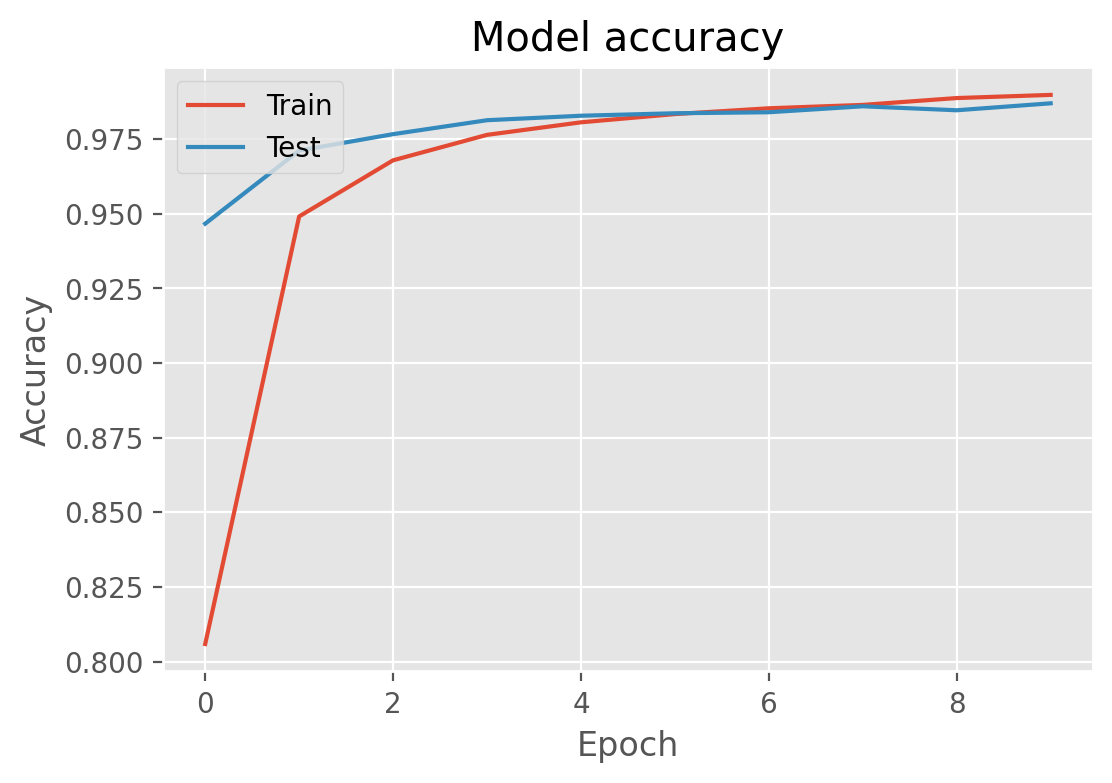

In [70]:
plt.figure(dpi=200)
plt.style.use('ggplot')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])                                                       
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig('plotAcc.png')

## Training the model

## Testing


## Plots

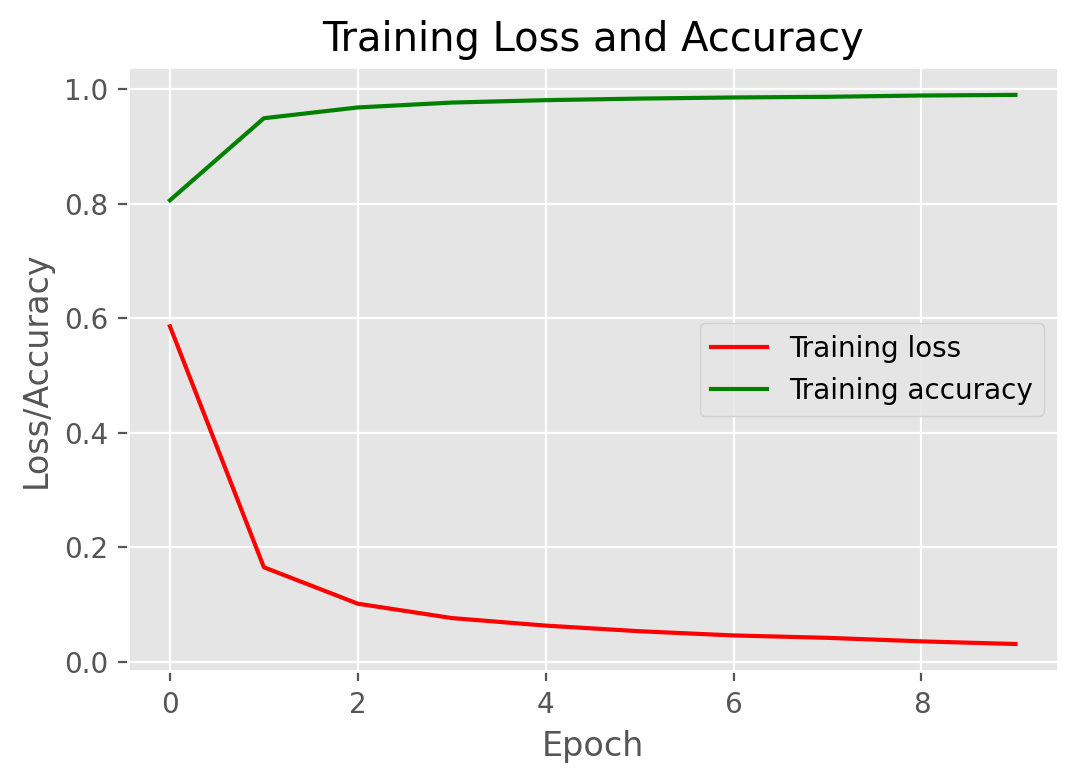

In [71]:
num_epochs = np.arange(0, 10)
plt.figure(dpi=200)
plt.style.use('ggplot')
plt.plot(num_epochs, history.history['loss'], label='Training loss', c='red')
plt.plot(num_epochs, history.history['accuracy'], label='Training accuracy', c='green')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.savefig('plot.png')
